In [37]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
import shap
import rfpimp
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid

# from parfit.fit import *
# from parfit.score import *
# from parfit.plot import *
# from parfit.crossval import *

In [2]:
path= '../data/'

In [3]:
! ls {path}

bookkeeper-data data-final      database.sqlite


In [4]:
data_final = pd.read_pickle(path+'data-final')

In [5]:
# repetetive column

data_final.drop('league_id_y', axis=1, inplace=True)

In [6]:
data_final.shape

(8045, 968)

In [7]:
data_final[:6]

,id,country_id,league_id_x,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_defenceAggression,away_defenceAggression,home_defenceAggressionClass,away_defenceAggressionClass,home_defenceTeamWidth,away_defenceTeamWidth,home_defenceTeamWidthClass,away_defenceTeamWidthClass,home_defenceDefenderLineClass,away_defenceDefenderLineClass
0,1729,1729,1729,2008/2009,1,2008-08-17,489042,10260,10261,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1730,1729,1729,2008/2009,1,2008-08-16,489043,9825,8659,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1731,1729,1729,2008/2009,1,2008-08-16,489044,8472,8650,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1732,1729,1729,2008/2009,1,2008-08-16,489045,8654,8528,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1734,1729,1729,2008/2009,1,2008-08-16,489047,8668,8655,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1735,1729,1729,2008/2009,1,2008-08-16,489048,8549,8586,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
bookkeeper_data = pd.read_feather(path+'bookkeeper-data')

In [9]:
bookkeeper_data[:2]

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,match_api_id
0,1.29,5.5,11.0,1.30,4.75,8.25,1.3,4.4,8.5,1.25,...,1.28,5.5,12.0,1.30,4.75,10.0,1.29,4.5,11.0,489042
1,1.20,6.5,15.0,1.22,5.50,10.00,1.2,5.2,11.0,1.20,...,1.25,6.0,13.0,1.22,5.50,13.0,1.22,5.0,13.0,489043


In [10]:
bookkeeper_data.shape

(8045, 31)

* Training : upto last-2 seasons of each league
* Validation : 2nd last season
* Test: last season

In [11]:
# data is only for 3 leagues

data_final.league_id_x.unique()

array([ 1729,  7809, 21518], dtype=uint64)

In [12]:
# adding year column

data_final['year'] = data_final.date.dt.year

In [13]:
league_years = data_final[['league_id_x','year']].drop_duplicates().reset_index(drop=True)

In [14]:
league_years

,league_id_x,year
0,1729,2008
1,1729,2009
2,1729,2010
3,1729,2011
4,1729,2012
5,1729,2013
6,1729,2014
7,1729,2015
8,1729,2016
9,7809,2008


In [15]:
# validation set

val_yr_lg = league_years.groupby('league_id_x').tail(2).groupby('league_id_x').head(1)
val_yr_lg

,league_id_x,year
7,1729,2015
16,7809,2015
25,21518,2015


In [16]:
# test set

test_yr_lg = league_years.groupby('league_id_x').tail(1)
test_yr_lg

,league_id_x,year
8,1729,2016
17,7809,2016
26,21518,2016


### More features and null treatment

In [17]:
data_final['month'] = data_final.date.dt.month
data_final['dow'] = data_final.date.dt.dayofweek
data_final['hour '] = data_final.date.dt.hour

In [18]:
def convert_cats(train, col_not_convert = [], test = None):
    """
    Convert columns in a training and test dataframe
    into category codes 
    
    train: Training dataframe
    col_not_convert: list of columns which are string type and which you don't want to convert
    test: Test/ Validation set (Mapping from category codes from training)
    """
    
    for n,c in train.items():
        if is_string_dtype(c) and n not in col_not_convert : train[n] = c.astype('category').cat.as_ordered()
    
    if test is not None:
        for n,c in test.items():
            if (n in train.columns) and (train[n].dtype.name=='category'):
                test[n] = pd.Categorical(c, categories=train[n].cat.categories, ordered=True)
            
    cols = list(train.columns[train.dtypes == 'category'])
    for c in cols:
        train[c] = train[c].astype('category').cat.codes
        if test is not None: test[c] = test[c].astype('category').cat.codes

In [19]:
# convert string to cats

convert_cats(data_final)

In [20]:
# removing nulls from int/float based columns, replace with -1 as this is what we did for string type also

data_final.fillna(-1, inplace=True)

In [21]:
data_final[:2]

,id,country_id,league_id_x,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_defenceTeamWidth,away_defenceTeamWidth,home_defenceTeamWidthClass,away_defenceTeamWidthClass,home_defenceDefenderLineClass,away_defenceDefenderLineClass,year,month,dow,hour
0,1729,1729,1729,0,1,2008-08-17,489042,10260,10261,1,...,-1,-1.0,-1,-1.0,-1,-1,2008,8,6,0
1,1730,1729,1729,0,1,2008-08-16,489043,9825,8659,1,...,-1,-1.0,-1,-1.0,-1,-1,2008,8,5,0


In [22]:
# don't need id and date column

data_final.drop(['id','date'],axis=1, inplace=True)

In [23]:
data_final.drop(['home_team_goal', 'away_team_goal','goal'], axis=1, inplace=True)

Making lineup of home and way players

In [24]:
data_final['away_lineup'] = data_final[['away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4',
       'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'away_player_Y9', 'away_player_Y10', 'away_player_Y11']].astype(str).add('_').sum(axis=1).str[:-1]

In [25]:
data_final['home_lineup'] = data_final[['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8',
       'home_player_X9', 'home_player_X10', 'home_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8',
       'home_player_Y9', 'home_player_Y10', 'home_player_Y11']].astype(str).add('_').sum(axis=1).str[:-1]

In [26]:
id_cols_to_rem = list(data_final.filter(regex='id$').columns) + list(data_final.filter(regex='\d$').columns)

In [27]:
data_final.drop(id_cols_to_rem, axis=1, inplace=True)

In [28]:
# new cols were string

convert_cats(data_final)

### Splitting data into train, validation and test 

In [29]:
train = data_final[(data_final.year!=2016) & (data_final.year!=2015) & (data_final.year!=2014)]
val1 = data_final[data_final.year==2014]
train_val1 = data_final[(data_final.year!=2016) & (data_final.year!=2015)]
val2 = data_final[data_final.year==2015]

# completely hold out
test = data_final[data_final.year==2016]

In [30]:
train.shape, val1.shape, train_val1.shape, val2.shape, test.shape

((5423, 899), (1038, 899), (6461, 899), (1051, 899), (533, 899))

In [40]:
x_train, y_train = train.drop('outcome', axis=1), train['outcome']
x_val1, y_val1 = val1.drop('outcome', axis=1), val1['outcome']
x_val2, y_val2 = val2.drop('outcome', axis=1), val2['outcome']

### Random Forest

Multiclass without callibration

In [86]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=200, random_state=10)
m.fit(train_val1.drop('outcome', axis=1), train_val1['outcome'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [87]:
m_probs = m.predict_proba(val2.drop('outcome', axis=1))
score = log_loss(val2['outcome'], m_probs)
score

1.0118141042237716

In [88]:
m_probs[:10]

array([[0.26 , 0.305, 0.435],
       [0.39 , 0.33 , 0.28 ],
       [0.22 , 0.21 , 0.57 ],
       [0.12 , 0.16 , 0.72 ],
       [0.21 , 0.255, 0.535],
       [0.215, 0.285, 0.5  ],
       [0.37 , 0.31 , 0.32 ],
       [0.445, 0.325, 0.23 ],
       [0.575, 0.195, 0.23 ],
       [0.265, 0.24 , 0.495]])

In [89]:
m.score(val2.drop('outcome', axis=1), val2['outcome'])

0.5033301617507137

Multiclass with callibration 

In [81]:
m2 = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=10)
m2.fit(train.drop('outcome', axis=1), train['outcome'])
m2_probs = m2.predict_proba(val1.drop('outcome', axis=1))

sig_m2 = CalibratedClassifierCV(m2, method="sigmoid", cv="prefit")
sig_m2.fit(val1.drop('outcome', axis=1), val1['outcome'])  # final callibrated model
sig_m2_probs = sig_m2.predict_proba(val2.drop('outcome', axis=1))
sig_score = log_loss(val2['outcome'], sig_m2_probs)

print('logloss : ', sig_score)

logloss :  0.9980382448512757


In [82]:
sig_m2.score(x_val2, y_val2)

0.5137963843958135

#### Hyperparameter tuning

In [49]:
def fitOne(model, x_train, y_train, x_val1, y_val1, params):

    model.set_params(**params)
    m = model.fit(x_train, y_train)
    
    sig_mod = CalibratedClassifierCV(m, method="sigmoid", cv="prefit")
    return sig_mod.fit(x_val1, y_val1)

def fitModels(model, paramGrid, x_train, y_train, x_val1, y_val1, n_jobs=-1, verbose=10):

    return Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(fitOne)(model,
                                                                    x_train,
                                                                    y_train, 
                                                                    x_val1,
                                                                    y_val1,
                                                                    params) for params in paramGrid)

def scoreOne(model, x,y, metric):
    probs = model.predict_proba(x)
    return log_loss(y, probs)


def scoreModels(models, X, y, metric=log_loss, predict_proba=True, n_jobs=-1, verbose=10):

    return Parallel(n_jobs=n_jobs, verbose=np.ceil(verbose/10))(delayed(scoreOne)(m,
                                                                      X,
                                                                      y,
                                                                      metric) for m in models)


def getBestModel(models, scores, greater_is_better=False):

    if greater_is_better:
        return models[np.argmax(scores)]
    else:
        return models[np.argmin(scores)]


def getBestScore(scores, greater_is_better=False):
    
    if greater_is_better:
        return np.max(scores)
    else:
        return np.min(scores)

def bestFit(model, paramGrid, x_train, y_train, x_val1, y_val1, x_val2, y_val2, 
            metric=log_loss, greater_is_better=False, predict_proba=True,
            scoreLabel=None, vrange=None, cmap='YlOrRd', n_jobs=-1, verbose=10):
    print('-------------FITTING MODELS-------------')
    models = fitModels(model, paramGrid, x_train, y_train, x_val1, y_val1, n_jobs, verbose)
    print('-------------SCORING MODELS-------------')
    scores = scoreModels(models, x_val2, y_val2, metric,
                         predict_proba, n_jobs, verbose)

    return getBestModel(models, scores, greater_is_better), getBestScore(scores, greater_is_better), models, scores


In [57]:
grid = {
    'min_samples_leaf': [1, 5, 10, 15, 20, 25],
    'max_features': ['sqrt', 'log2', 0.5],
    'n_estimators': [100],
    'n_jobs': [-1],
    'random_state': [10]
}
paramGrid = ParameterGrid(grid)

In [58]:
best_model, best_score, all_models, all_scores = bestFit(RandomForestClassifier(), paramGrid,
                                                    x_train, y_train, x_val1, y_val1, x_val2, y_val2,
                                                    metric=roc_auc_score, greater_is_better=False, 
                                                    scoreLabel='log_loss')

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  2.2min remaining:   51.7s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  2.9min remaining:   34.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.5min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished


In [68]:
best_score

0.9912403806973626

In [62]:
best_model

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
            cv='prefit', method='sigmoid')

In [63]:
best_model.score(x_val2, y_val2)

0.5147478591817317

#### Feature importance

In [83]:
imp = rfpimp.importances(best_model, x_val2 , y_val2) # permutation

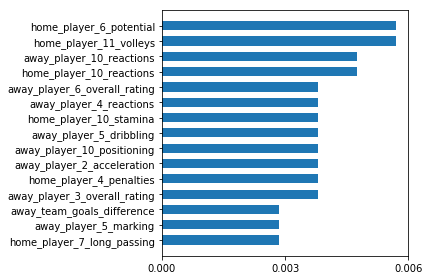

In [85]:
rfpimp.plot_importances(imp[-15:])

In [90]:
imp2 = rfpimp.importances(m, x_val2 , y_val2) # permutation

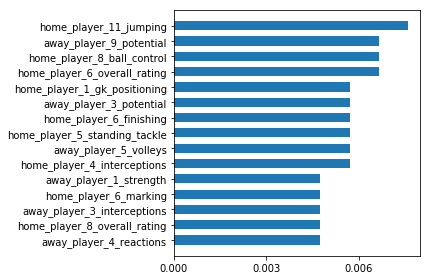

In [91]:
rfpimp.plot_importances(imp2[-15:])

## End